# 구축한 학습 데이터로 학습 완료
## 멀티 클래스 분류 방법 확인 완료 !!!!!!!!

진열된 상품 확인 후 모델을 통해 상품분류?  
데이터 품질 문제 있음 - 사과, 과자 등 학습용 데이터의 품질을 높일 필요가 있음

메모리 에러  
CUDA error: device-side assert triggered

In [2]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.extend(['./tmp/packages/detr/'])

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [1]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        
    @property
    def avg(self):
        return (self.sum / self.count) if self.count>0 else 0

In [3]:
n_folds = 5
seed = 42
null_class_coef = 0.5
num_classes = 9 # class 수 변경
num_queries = 100
BATCH_SIZE = 8
LR = 5e-5
lr_dict = {'backbone':0.1,'transformer':1,'embed':1,'final': 5}
EPOCHS = 2
max_norm = 0
model_name = 'detr_resnet50'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
seed_everything(seed)

In [6]:
marking = pd.read_csv('/home/lab10/JJC/EasyFree-Backend/IMAGE/coco_train.csv').reset_index()
marking.columns = ['bg_name','category','x','y','w','h','source']
marking

,bg_name,category,x,y,w,h,source
0,et_a_1,carrot,82,726,92,103,emart_2
1,et_a_1,lemon,290,870,75,74,emart_2
2,et_a_1,carrot,889,706,83,56,emart_2
3,et_a_2,pumpkin,272,569,68,84,emart_4
4,et_a_2,banana,773,59,86,73,emart_4
...,...,...,...,...,...,...,...
70510,et_a_9998,carrot,564,370,79,73,emart_3
70511,et_a_10000,banana,42,191,89,72,emart_2
70512,et_a_10000,watermelon,645,854,81,65,emart_2
70513,et_a_10000,sesame,556,534,80,95,emart_2


In [7]:
# labels 값은 1부터 Length까지
i=0
category_to_label = {}
for c in marking['category'].unique():
    i+=1
    category_to_label[c] = i

In [8]:
category_to_label

{'carrot': 1,
 'lemon': 2,
 'pumpkin': 3,
 'banana': 4,
 'sesame': 5,
 'watermelon': 6,
 'potato': 7,
 'apple': 8}

In [9]:
CLASSES = ['N/A']
CLASSES.extend(list(category_to_label.keys()))
CLASSES

['N/A',
 'carrot',
 'lemon',
 'pumpkin',
 'banana',
 'sesame',
 'watermelon',
 'potato',
 'apple']

In [10]:
# temp = pd.read_csv('/home/lab10/JJC/EasyFree-Backend/COLLECT_DATA/emart_category.csv')
# CATEGORY_LIST = []
# for c in CLASSES:
#     CATEGORY_LIST.append(temp[temp['category_number'] == c]['category_name'].values[0])
# CATEGORY_LIST.append('N/A')
# CATEGORY_LIST

In [11]:
# 카테고리 값 변경
marking['category'] = marking['category'].apply(lambda i : category_to_label[i])

In [12]:
# 이미지 파일명과 source(?), 박스 정보를 가져옴

image_data = marking.groupby('bg_name')
images = list(map(lambda x: x.split('.')[0], os.listdir('../../IMAGE/Train_Image')))

def get_data(img_id):
    if img_id not in image_data.groups:
        return dict(image_id=img_id, source='', boxes=list())
    
    data  = image_data.get_group(img_id)
    source = np.unique(data.source.values)
    assert len(source)==1, 'corrupted data: %s image_id has many sources: %s' %(img_id,source)
    source=source[0]
    boxes = data[['x','y','w','h']].values
    labels = data['category'].values
    return dict(image_id = img_id, boxes = boxes, labels = labels, source=source)

image_list = [get_data(img_id) for img_id in images]

In [13]:
image_list[1847]

{'image_id': 'et_a_955',
 'boxes': array([[942, 303,  80,  90],
        [253, 675,  78,  83],
        [287, 345, 111, 104],
        [ 41, 821, 104,  95],
        [150, 258,  79,  79],
        [235, 597, 101,  73],
        [310, 457,  65,  72]]),
 'labels': array([6, 3, 6, 2, 8, 4, 8]),
 'source': 'emart_4'}

In [14]:
print(f'total number of images: {len(image_list)}, images with bboxes: {len(image_data)}')
null_images=[x['image_id'] for x in image_list if len(x['boxes'])==0]
len(null_images)

total number of images: 10000, images with bboxes: 9351


649

In [15]:
def add_fold_index(lst,n_folds):
    lens = [len(x['boxes']) for x in lst]
    lens_unique = np.unique(lens)
    i = np.random.randint(n_folds)
    fold_indexes = [[] for _ in range(n_folds)]
    idx = []
    
    for _l in lens_unique:
        idx.extend(np.nonzero(lens==_l)[0].tolist())
        if len(idx)<n_folds: continue
        random.shuffle(idx)
        while len(idx)>= n_folds:
            fold_indexes[i].append(lst[idx.pop()]['image_id'])
            i = (i+1) % n_folds
    while len(idx):
        fold_indexes[i].append(lst[idx.pop()]['image_id'])
        i = (i+1) % n_folds
    
    return fold_indexes
    
sources = np.unique([x['source'] for x in image_list])
splitted_image_list = {s:sorted([x for x in image_list if x['source']==s],key=lambda x: len(x['boxes'])) 
                       for s in sources}
splitted_image_list = {k: add_fold_index(v,n_folds=n_folds) for k,v in splitted_image_list.items()}

fold_indexes = [[] for _ in range(n_folds)]
for k,v in splitted_image_list.items():
    for i in range(n_folds):
        fold_indexes[i].extend(v[i])  
    
print([len(v) for v in fold_indexes])

[2001, 2001, 1999, 1998, 2001]


In [16]:
# True로 할 시 박스 정보 없는 데이터 보여줌
if False:
    plt.figure(figsize=(10,10))
    for i,img in enumerate(null_images):
        if i==50:break
        plt.subplot(7,7,i+1)
        plt.imshow(plt.imread(f'../../IMAGE/Train_Image/{img}.jpg'))
        plt.axis('off')
        plt.axis('tight')
        plt.axis('equal')

    plt.show()

In [17]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf(
            [
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),      
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
            ],
            p=0.9),         
            #A.ToGray(p=0.01),         
            A.HorizontalFlip(p=0.5),         
            A.VerticalFlip(p=0.5),         
            A.Resize(height=512, width=512, p=1),      
            A.Normalize(max_pixel_value=1),
            #A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0)
        ], 
        p=1.0,         
        bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
        )

def get_valid_transforms():
    return A.Compose([
                      A.Resize(height=512, width=512, p=1.0),
                      A.Normalize(max_pixel_value=1),
                      ToTensorV2(p=1.0),
                      ], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

In [18]:
DIR_TRAIN = '../../IMAGE/Train_Image'
class WheatDataset(Dataset):
    def __init__(self,image_list,transforms=None):
        self.images = image_list
        self.transforms = transforms
        self.img_ids = {x['image_id']:i for i,x in enumerate(image_list)}
        
    def get_indices(self,img_ids):
        return [self.img_ids[x] for x in img_ids]
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self,index):
        record = self.images[index]
        image_id = record['image_id']

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = record['boxes'] 
        
        ################################### Box 라벨링 하는 곳 - 값 받아서 처리 - image별로 box 에 따라 라벨이 정해짐, 나중에 변경
        # image_list에 labels 부분을 만들어서 사용
        labels = np.asarray(record['labels'], dtype=np.int32) if len(boxes) else np.zeros(len(boxes), dtype=np.int32)
        # labels = np.zeros(len(boxes), dtype=np.int32)
        # labels[len(labels)//3:2*len(labels)//3] = 1
        # labels[2*len(labels)//3:] = 2

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image  = sample['image']
            boxes  = sample['bboxes']
            labels = sample['labels']

        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        ## detr uses center_x,center_y,width,height !!
        if len(boxes)>0:
            boxes = np.array(boxes)
            boxes[:,2:] /= 2
            boxes[:,:2] += boxes[:,2:]
        else:
            boxes = np.zeros((0,4))
    
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image'] = torch.tensor([index])
        
        return image, target, image_id

In [19]:
image_list[33]

{'image_id': 'et_a_1281',
 'boxes': array([[302, 724,  79,  94],
        [920, 622,  76,  67],
        [298, 122, 111,  87],
        [922, 901,  88,  80],
        [799, 616,  79,  90],
        [ 43, 186,  84,  72],
        [803, 245,  74,  88],
        [607, 615,  67,  77],
        [934, 755,  88,  54],
        [890, 327, 104, 104],
        [778, 496,  97,  76],
        [187, 675,  81,  88],
        [278, 911,  90,  50]]),
 'labels': array([3, 2, 6, 2, 8, 3, 5, 8, 1, 6, 7, 3, 1]),
 'source': 'emart_5'}

In [20]:
train_ds = WheatDataset(image_list,get_train_transforms())
valid_ds = WheatDataset(image_list,get_valid_transforms())

In [21]:
def show_example(image,target,image_id=None):
    np_image = image.cpu().numpy().transpose((1,2,0))
    # unnormalize the image
    np_image = np_image * np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    # np_image = (np_image*255).astype(np.uint8)
    target = {k: v.cpu().numpy() for k, v in target.items()}
    
    # target : 학습용 박스 정보
    # print(target)
    
    boxes = target['boxes']
    h,w,_ = np_image.shape
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for i, box in enumerate(boxes):
        cv2.rectangle(np_image,
                  (box[0]-box[2], box[1]-box[3]),
                  (box[2]+box[0], box[3]+box[1]),
                  # 라벨별 박스 색깔 변경
                  (220, 0, 0) if target['labels'][i] == 0 else (0,220,0) if target['labels'][i] == 1 else (0,0,220) , 1)
        
    ax.set_axis_off()
    ax.imshow(np_image)
    ax.set_title(image_id)
    plt.show()


In [22]:
# show_example(*train_ds[120])

In [23]:
def DETRModel(num_classes,model_name=model_name):
    model = torch.hub.load('facebookresearch/detr', model_name, pretrained=False, num_classes=num_classes)
    def parameter_groups(self):
        return { 'backbone': [p for n,p in self.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
                 'transformer': [p for n,p in self.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
                 'embed': [p for n,p in self.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad]}
    setattr(type(model),'parameter_groups',parameter_groups)
    return model

class DETRModel(nn.Module):
    def __init__(self,num_classes=1):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        
        self.model = torch.hub.load('facebookresearch/detr', model_name, pretrained=True)
        
        self.out = nn.Linear(in_features=self.model.class_embed.out_features,out_features=num_classes+1)
        
    def forward(self,images):
        d = self.model(images)
        d['pred_logits'] = self.out(d['pred_logits'])
        return d
    
    def parameter_groups(self):
        return { 
            'backbone': [p for n,p in self.model.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
            'transformer': [p for n,p in self.model.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
            'embed': [p for n,p in self.model.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad],
            'final': self.out.parameters()
            }

In [24]:
model = DETRModel(num_classes = num_classes)
model.parameter_groups().keys()
#type(model)

Using cache found in /home/lab10/.cache/torch/hub/facebookresearch_detr_master


dict_keys(['backbone', 'transformer', 'embed', 'final'])

In [25]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher(cost_giou=2,cost_class=1,cost_bbox=5)

weight_dict = {'loss_ce': 1, 'loss_bbox': 5 , 'loss_giou': 2}

losses = ['labels', 'boxes', 'cardinality']

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [27]:
# 데이터를 Torch DataLoader 형식으로 변환

def get_fold(fold):
    
    train_indexes = train_ds.get_indices([x for i,f in enumerate(fold_indexes) if i!=fold for x in f])
    valid_indexes = valid_ds.get_indices(fold_indexes[fold])
    
    train_data_loader = DataLoader(
        torch.utils.data.Subset(train_ds,train_indexes),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        torch.utils.data.Subset(valid_ds,valid_indexes),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )
    return train_data_loader,valid_data_loader

In [28]:
train_loader,valid_loader = get_fold(0)

In [29]:
valid_iter = iter(valid_loader)
# batch  = next(valid_iter)

In [30]:
import util.box_ops  as box_ops

def challenge_metric(outputs,targets):
    logits = outputs['pred_logits']
    boxes  = outputs['pred_boxes']
    return sum(avg_precision(logit[:,0]-logit[:,1],box,target['boxes'])
            for logit,box,target in zip(logits,boxes,targets))/len(logits)

    return {target['image_id']:avg_precision(logit[:,0]-logit[:,1],box,target['boxes'])
            for logit,box,target in zip(logits,boxes,targets)}


@torch.no_grad()
def avg_precision(logit,pboxes,tboxes,reduce=True):
    idx = logit.gt(0)
    if sum(idx)==0 and len(tboxes)==0: 
        return 1 if reduce else [1]*6
    if sum(idx)>0 and len(tboxes)==0: 
        return 0 if reduce else [0]*6
    
    pboxes = pboxes[idx]
    logit = logit[idx]
    
    idx = logit.argsort(descending=True)
    pboxes=box_ops.box_cxcywh_to_xyxy(pboxes.detach()[idx])
    tboxes=box_ops.box_cxcywh_to_xyxy(tboxes)
    
    iou = box_ops.box_iou(pboxes,tboxes)[0].cpu().numpy()
    prec = [precision(iou,th) for th in [0.5,0.55,0.6,0.65,0.7,0.75]]
    if reduce:
        return sum(prec)/6
    return prec
    

def precision(iou,th):
    #if iou.shape==(0,0): return 1

    #if min(*iou.shape)==0: return 0
    tp = 0
    iou = iou.copy()
    num_pred,num_gt = iou.shape
    for i in range(num_pred):
        _iou = iou[i]
        n_hits = (_iou>th).sum()
        if n_hits>0:
            tp += 1
            j = np.argmax(_iou)
            iou[:,j] = 0
    return tp/(num_pred+num_gt-tp)

In [31]:
def gen_box(n,scale=1):
    par = torch.randn((n,4)).mul(scale).sigmoid() 
    max_hw = 2*torch.min(par[:,:2],1-par[:,:2])
    par[:,2:] = par[:,2:].min(max_hw)
    return par

pboxes = gen_box(50)
logit = torch.randn(50)
tboxes = gen_box(3)

avg_precision(logit,pboxes,tboxes)
#iou.gt(0.5),iou,pboxes,tboxes

0.02955665024630542

In [32]:
# 학습 함수
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    tk0 = tqdm(data_loader, total=len(data_loader),leave=False)
    log = None
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        batch_size = len(images)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        output = model(images)
        
        loss_dict = criterion(output, targets)
        
        if log is None:
            log = {k:AverageMeter() for k in loss_dict}
            log['total_loss'] = AverageMeter()
            log['avg_prec'] = AverageMeter()
            
        weight_dict = criterion.weight_dict
        
        total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        total_loss.backward()
        
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        log['total_loss'].update(total_loss.item(),batch_size)
        
        for k,v in loss_dict.items():
            log[k].update(v.item(),batch_size)
            
        log['avg_prec'].update(challenge_metric(output,targets),batch_size)
            
        tk0.set_postfix({k:v.avg for k,v in log.items()}) 
        
    return log

In [33]:
# 평가 함수
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    log = None
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader),leave=False)
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            batch_size = len(images)
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            if log is None:
                log = {k:AverageMeter() for k in loss_dict}
                log['total_loss'] = AverageMeter()
                log['avg_prec'] = AverageMeter()
            
            for k,v in loss_dict.items():
                log[k].update(v.item(),batch_size)
        
            total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            log['total_loss'].update(total_loss.item(),batch_size)
            log['avg_prec'].update(challenge_metric(output,targets),batch_size)
            
            tk0.set_postfix({k:v.avg for k,v in log.items()}) 
    
    return log #['total_loss']

In [34]:
# 실행 로그 처리, Run 함수

import json

class Logger:
    def __init__(self,filename,format='csv'):
        self.filename = filename + '.' + format
        self._log = []
        self.format = format
    def save(self,log,epoch=None):
        log['epoch'] = epoch+1
        self._log.append(log)
        if self.format == 'json':
            with open(self.filename,'w') as f:
                json.dump(self._log,f)
        else:
            pd.DataFrame(self._log).to_csv(self.filename,index=False)
            
            
def run(fold,epochs=EPOCHS):
    
    train_data_loader,valid_data_loader = get_fold(fold)
    
    logger = Logger(f'log_{fold}')
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes)
    model = model.to(device)
    criterion = SetCriterion(num_classes, 
                             matcher, weight_dict, 
                             eos_coef = null_class_coef, 
                             losses=losses)
    
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW([{
        'params': v,
        'lr': lr_dict.get(k,1)*LR
    } for k,v in model.parameter_groups().items()], weight_decay=1e-4)
    
    best_precision = 0
    header_printed = False
    for epoch in range(epochs):
        train_log = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_log = eval_fn(valid_data_loader, model,criterion, device)
    
        log = {k:v.avg for k,v in train_log.items()}
        log.update({'V/'+k:v.avg for k,v in valid_log.items()})
        logger.save(log,epoch)
        keys = sorted(log.keys())
        
        if not header_printed:
            print(' '.join(map(lambda k: f'{k[:8]:8}',keys)))
            header_printed = True
        print(' '.join(map(lambda k: f'{log[k]:8.3f}'[:8],keys)))
        
        # if log['V/avg_prec'] > best_precision:
        best_precision = log['V/avg_prec']
        print('Best model found at epoch {}'.format(epoch+1))
        torch.save(model.state_dict(), f'./detr_best_{fold}.pth')
    

In [35]:
import gc
gc.collect()

13

In [36]:
run(fold=0,epochs=10)

Using cache found in /home/lab10/.cache/torch/hub/facebookresearch_detr_master


V/avg_pr V/cardin V/class_ V/loss_b V/loss_c V/loss_g V/total_ avg_prec cardinal class_er epoch    loss_bbo loss_ce  loss_gio total_lo
   0.067    0.584   21.321    0.010    0.117    0.244    0.655    0.065    2.514   53.720    1.000    0.013    0.304    0.289    0.950
Best model found at epoch 1


   0.065    0.402   13.540    0.010    0.068    0.227    0.570    0.066    0.696   19.237    2.000    0.012    0.133    0.285    0.763
Best model found at epoch 2


   0.065    0.421   12.246    0.011    0.064    0.263    0.646    0.065    0.581   12.965    3.000    0.013    0.103    0.284    0.734
Best model found at epoch 3


   0.065    0.392   11.888    0.010    0.056    0.230    0.564    0.065    0.530    9.921    4.000    0.011    0.082    0.270    0.679
Best model found at epoch 4


   0.065    0.343   10.868    0.010    0.048    0.249    0.594    0.065    0.553    9.678    5.000    0.011    0.077    0.268    0.670
Best model found at epoch 5


   0.065    0.402   10.953    0.009    0.045    0.214    0.516    0.065    0.505    8.296    6.000    0.011    0.068    0.260    0.642
Best model found at epoch 6


   0.065    0.350    9.692    0.009    0.038    0.219    0.520    0.065    0.522    8.486    7.000    0.011    0.069    0.264    0.651
Best model found at epoch 7


   0.065    0.306    9.483    0.008    0.034    0.208    0.490    0.065    0.477    7.214    8.000    0.010    0.061    0.250    0.612
Best model found at epoch 8


   0.065    0.274    9.426    0.007    0.032    0.181    0.429    0.065    0.477    6.817    9.000    0.010    0.058    0.248    0.604
Best model found at epoch 9


   0.065    0.313    9.927    0.008    0.036    0.197    0.467    0.065    0.471    6.511   10.000    0.010    0.057    0.247    0.600
Best model found at epoch 10


In [120]:
def show_predictions(images,outputs,targets):
    _,h,w = images[0].shape
    
    boxes = targets[0]['boxes'].cpu().numpy() #.astype(np.int32)
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    np_image = images[0].permute(1,2,0).cpu().numpy()
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    
    #outputs = [{k: v.cpu() for k, v in output.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    labels = targets[0]['labels']
    for box, label in zip(boxes, labels):
        x, y = (box[0]-box[2], box[1]-box[3])
        cv2.rectangle(np_image,
                  (box[0]-box[2], box[1]-box[3]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 2)
        # CATEGORY_NAME = str(CATEGORY_LIST[label-1])
        # cv2.putText(np_image, CATEGORY_NAME, (x, y-1), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (220,0,0), 2)
    
    oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    # prob   = outputs['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0] # 2진 분류
    prob   = outputs['pred_logits'].softmax(-1).detach().cpu().numpy()[0, :, :-1] # 멀티클래스 분류
    for box,p in zip(oboxes,prob):
        cl = p.argmax()
        if p[cl] > 0.5:
            # color = (0,0,220) if p>0.5 else (0,220,0)
            color = (0,0,220)
            x, y = box[0]-box[2], box[1]-box[3]
            cv2.rectangle(np_image,
                        (x, y),
                        (box[2]+box[0], box[3]+box[1]),
                        color, 1)
            CATEGORY_NAME = CLASSES[cl]
            text = f'{CATEGORY_NAME}: {p[cl]:0.2f}'
            cv2.putText(np_image, text, (x, y-1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    ax.set_axis_off()
    ax.imshow(np_image)
    #return images,outputs,targets

In [40]:
model = DETRModel(num_classes=num_classes)#num_classes,num_queries=num_queries
# THIS_PATH = '/home/lab10/.cache/torch/hub/facebookresearch_detr_master'
ORIGINAL_PATH = './detr_best_0.pth'
model.load_state_dict(torch.load(ORIGINAL_PATH))
model.to(torch.device('cuda'))
None

Using cache found in /home/lab10/.cache/torch/hub/facebookresearch_detr_master


In [272]:
train_loader,valid_loader = get_fold(0)
valid_iter = iter(valid_loader)

In [326]:
images,targets,image_id = next(valid_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


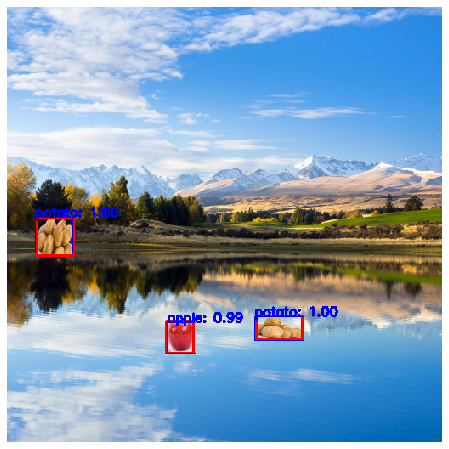

In [327]:
dev_images = [img.to(torch.device('cuda')) for img in images]
model.eval()
with torch.no_grad():
    # 예측
    outputs = model(dev_images)
outputs = {k: v.cpu() for k, v in outputs.items()}
show_predictions(images,outputs,targets)

## 모델 검증 (상품 진열 이미지)

In [ ]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.extend(['./tmp/packages/detr/'])

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [4]:
# lr_dict = {'backbone':0.1,'transformer':1,'embed':1,'final': 5}
model_name = 'detr_resnet50'

In [5]:
def DETRModel(num_classes,model_name=model_name):
    model = torch.hub.load('facebookresearch/detr', model_name, pretrained=False, num_classes=num_classes)
    def parameter_groups(self):
        return { 'backbone': [p for n,p in self.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
                 'transformer': [p for n,p in self.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
                 'embed': [p for n,p in self.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad]}
    setattr(type(model),'parameter_groups',parameter_groups)
    return model

class DETRModel(nn.Module):
    def __init__(self,num_classes=1):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        
        self.model = torch.hub.load('facebookresearch/detr', model_name, pretrained=True)
        
        self.out = nn.Linear(in_features=self.model.class_embed.out_features,out_features=num_classes+1)
        
    def forward(self,images):
        d = self.model(images)
        d['pred_logits'] = self.out(d['pred_logits'])
        return d
    
    def parameter_groups(self):
        return { 
            'backbone': [p for n,p in self.model.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
            'transformer': [p for n,p in self.model.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
            'embed': [p for n,p in self.model.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad],
            'final': self.out.parameters()
            }

In [6]:
model = DETRModel(num_classes=9)
ORIGINAL_PATH = './detr_best_0.pth'
model.load_state_dict(torch.load(ORIGINAL_PATH))
model.to(torch.device('cuda'))
None

Using cache found in /home/lab10/.cache/torch/hub/facebookresearch_detr_master


In [21]:
def show_pred(images, otuputs):
    im = transforms.ToPILImage()(images[0]).convert("RGB")
    h, w = im.size
    im = np.array(im)
    
    oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h, w)]
    print(len(oboxes))
    print(oboxes.values)
    prob   = outputs['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0] # 2진 분류
    color = (220,0,0)
    for box,p in zip(oboxes,prob):
        if p > 0.3:
            try:
                for i in range(box[0]-box[2],box[2]+box[0]):
                    im[box[1]-box[3]][i] = color
                    im[box[1]+box[3]][i] = color
                for j in range(box[1]-box[3], box[3]+box[1]):
                    im[j][box[0]-box[2]] = color
                    im[j][box[0]+box[2]] = color
            except:pass
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.imshow(im)

In [389]:
from PIL import Image
img = Image.open('/home/lab10/JJC/검증용/34613461.jpg')

In [390]:
img = img.resize((512,512))
img = img.convert('RGB')

In [391]:
from torchvision import transforms
pil_to_tensor = transforms.ToTensor()(img).unsqueeze_(0)
print(pil_to_tensor.shape)

torch.Size([1, 3, 512, 512])


t is:  torch.Size([1, 3, 512, 512])


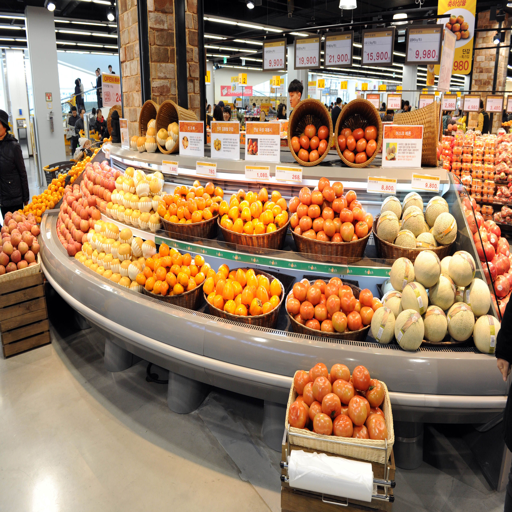

<PIL.Image.Image image mode=RGB size=512x512 at 0x7FC4A6C287B8>
(512, 512)


In [392]:
print("t is: ", pil_to_tensor.size())

im = transforms.ToPILImage()(pil_to_tensor[0]).convert("RGB")
display(im)
print(im)
print(im.size)

In [393]:
def show_predictions(images,outputs):
    _,h,w = images[0].shape
    np_image = images[0].permute(1,2,0).cpu().numpy()
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs['pred_logits'].softmax(-1).detach().cpu().numpy()[0, :, :-1] # 멀티클래스 분류
    for box,p in zip(oboxes,prob):
        cl = p.argmax()
        if p[cl] > 0.01:
            color = (0,0,220)
            x, y = box[0]-box[2], box[1]-box[3]
            cv2.rectangle(np_image,
                        (x, y),
                        (box[2]+box[0], box[3]+box[1]),
                        color, 1)
            CATEGORY_NAME = CLASSES[cl]
            text = f'{CATEGORY_NAME}: {p[cl]:0.2f}'
            cv2.putText(np_image, text, (x, y-1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    ax.set_axis_off()
    ax.imshow(np_image)

In [402]:
def show_pred(images, otuputs):
    im = transforms.ToPILImage()(images[0]).convert("RGB")
    h, w = im.size
    im = np.array(im)
    
    oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h, w)]
    
    prob   = outputs['pred_logits'].softmax(-1).detach().cpu().numpy()[0, :, :-1] # 멀티클래스 분류
    color  = (220,0,0)
    for box,p in zip(oboxes,prob):
        cl = p.argmax()
        # print(cl)
        if p[cl] > 0.01:
            # try:
            CATEGORY_NAME = CLASSES[cl]
            text = f'{CATEGORY_NAME}: {p[cl]:0.2f}'
            x1, x2, y1, y2 = box[0]-box[2], box[0]+box[2], box[1]-box[3], box[1]+box[3]
            cv2.putText(im, text, (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            for i in range(box[0]-box[2],box[2]+box[0]):
                im[box[1]-box[3]][i] = color
                im[box[1]+box[3]-1][i] = color
            for j in range(box[1]-box[3], box[3]+box[1]):
                im[j][box[0]-box[2]] = color
                im[j][box[0]+box[2]-1] = color
            # except:
            #     print('here')
            #     pass
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.imshow(im)

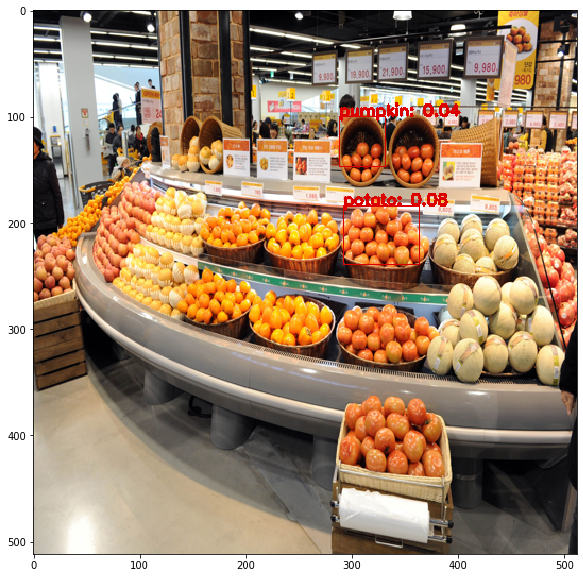

In [403]:
dev_images = [img.to(torch.device('cuda')) for img in pil_to_tensor]
model.eval()
with torch.no_grad():
    # 예측
    outputs = model(dev_images)
outputs = {k: v.cpu() for k, v in outputs.items()}
show_pred(pil_to_tensor,outputs)

In [54]:
outputs = model(dev_images)
outputs = {k: v.cpu() for k, v in outputs.items()}
oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,512, 512)]

# 서버통신용

In [ ]:
import os
import numpy as np
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.extend(['./tmp/packages/detr/'])

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [ ]:
!git clone https://github.com/facebookresearch/detr.git  ./tmp/packages/detr #cloning github repo of detr to import its unique loss
!ls ./tmp/packages/detr/*
!pip install torch
!pip install torchvision
!pip install albumentations

In [175]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
import albumentations as A

In [176]:
model_name = 'detr_resnet50'

In [180]:
def show_pred(otuputs):
    oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes, 512, 512)]
    
    prob   = outputs['pred_logits'].softmax(-1).detach().cpu().numpy()[0, :, :-1] # 멀티클래스 분류
    color = (220,0,0)
    for box,p in zip(oboxes,prob):
        cl = p.argmax()
        # if p[cl] > 0.3:
        try:
            x1, x2, y1, y2 = box[0]-box[2], box[0]+box[2], box[1]-box[3], box[1]+box[3]
            print(x1, x2, y1, y2, cl)
        except:pass

In [181]:
def DETRModel(num_classes,model_name=model_name):
    model = torch.hub.load('facebookresearch/detr', model_name, pretrained=False, num_classes=num_classes)
    def parameter_groups(self):
        return { 'backbone': [p for n,p in self.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
                 'transformer': [p for n,p in self.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
                 'embed': [p for n,p in self.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad]}
    setattr(type(model),'parameter_groups',parameter_groups)
    return model

class DETRModel(nn.Module):
    def __init__(self,num_classes=1):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        
        self.model = torch.hub.load('facebookresearch/detr', model_name, pretrained=True)
        
        self.out = nn.Linear(in_features=self.model.class_embed.out_features,out_features=num_classes+1)
        
    def forward(self,images):
        d = self.model(images)
        d['pred_logits'] = self.out(d['pred_logits'])
        return d
    
    def parameter_groups(self):
        return { 
            'backbone': [p for n,p in self.model.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
            'transformer': [p for n,p in self.model.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
            'embed': [p for n,p in self.model.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad],
            'final': self.out.parameters()
            }

In [182]:
model = DETRModel(num_classes=9) # 나중에 모델 수정 시 변경
ORIGINAL_PATH = './detr_best_0.pth'
model.load_state_dict(torch.load(ORIGINAL_PATH))
model.to(torch.device('cuda'))
None

# 들어온 데이터 (임시)
img = Image.open('/home/lab10/JJC/Untitled.jpg')
img = img.resize((512,512)).convert('RGB')
pil_to_tensor = transforms.ToTensor()(img).unsqueeze_(0)
dev_images = [img.to(torch.device('cuda')) for img in pil_to_tensor]
model.eval()
with torch.no_grad():
    outputs = model(dev_images)
outputs = {k: v.cpu() for k, v in outputs.items()}
show_pred(outputs)

Using cache found in /home/lab10/.cache/torch/hub/facebookresearch_detr_master
3 51 314 358 1
211 257 111 173 6
41 103 462 508 6
215 259 105 155 6
210 256 108 168 6
205 255 117 181 6
205 253 124 184 6
77 121 344 380 1
90 132 41 77 3
167 221 106 174 6
352 404 444 494 1
15 71 411 461 6
4 50 355 397 1
9 57 459 509 6
219 269 448 500 6
12 66 166 210 1
8 60 43 91 3
405 461 96 144 3
218 300 312 358 1
206 256 145 195 6
279 323 358 400 1
324 366 331 373 1
488 512 105 155 1
4 46 439 497 6
302 344 249 291 3
272 314 344 386 1
479 511 108 156 1
174 218 305 349 1
209 257 105 165 6
-4 36 154 206 3
3 47 352 400 1
202 244 383 425 1
31 89 464 510 6
477 511 112 162 1
480 512 115 169 1
208 254 113 177 6
6 50 345 391 1
79 121 258 296 3
152 198 371 409 1
360 408 151 195 3
470 510 111 159 2
477 511 107 155 1
213 259 109 169 6
196 242 374 420 1
6 56 195 239 1
203 257 108 180 6
14 76 229 279 3
250 294 386 432 1
-1 49 209 267 3
163 203 250 290 1
207 255 103 155 6
345 401 112 160 1
106 160 470 508 6
205 251 115 

In [ ]:
outputs = model(dev_images)
outputs = {k: v.cpu() for k, v in outputs.items()}
oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,512, 512)]